<a href="https://colab.research.google.com/github/r-doz/NeuroInferMix/blob/main/bnn_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!git clone https://github.com/r-doz/NeuroInferMix.git
#%cd /content/NeuroInferMix
#!git pull


fatal: destination path 'NeuroInferMix' already exists and is not an empty directory.


In [29]:
import sys
sys.path.append("/content/NeuroInferMix/src")
!pip install pyro-ppl
from representation.bayesian_nn import BNN_GMM
import torch
from representation.training import *
from representation.datasets import load_mnist_onehot_tensors
import pandas as pd
import numpy as np
import time

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#DATASET
pi_x = torch.ones(2, 3, 1, device=device)        # deterministic mixture
mu_x = torch.tensor([
    [[1.0], [2.0], [3.0]],   # batch 0
    [[-1.0], [0.5], [1.5]]   # batch 1
], device=device)

sigma_x = 0.01 * torch.ones_like(mu_x)

#BNN FORWARD
bnn = BNN_GMM(layer_sizes=[3, 10, 1], K=1, bias=True).to(device)

pi_out, mu_out, sg_out = bnn(pi_x, mu_x, sigma_x, max_components=100)
print(pi_out.shape)
print(mu_out.shape)
print(sg_out.shape)

#count how many components have non-zero weight
non_zero_components = (pi_out > 1e-12).sum(dim=2)
print("Non-zero components per batch sample:", non_zero_components)

torch.Size([2, 1, 61])
torch.Size([2, 1, 61])
torch.Size([2, 1, 61])
Non-zero components per batch sample: tensor([[12],
        [61]], device='cuda:0')


In [4]:
import torch.nn.functional as F
import math

def gmm_nll(pi, mu, sg, y, eps=1e-12):
    """
    Negative log-likelihood of targets y under a Gaussian mixture.
    Shapes:
      pi,mu,sg: (B, D, K)
      y:        (B, D) or (B, D, 1)

    Returns:
      scalar loss
    """
    if y.dim() == 2:
        y = y.unsqueeze(-1)  # (B, D, 1)

    sg = sg.clamp_min(eps)
    logpi = torch.log(pi.clamp_min(eps))  # (B, D, K)

    # log N(y | mu, sg)
    log_norm = -0.5 * torch.log(2.0 * torch.pi * (sg ** 2))
    log_exp = -0.5 * ((y - mu) / sg) ** 2
    logp = log_norm + log_exp  # (B, D, K)

    # logsumexp over components
    log_mix = torch.logsumexp(logpi + logp, dim=-1)  # (B, D)
    return (-log_mix).mean()

def classification_nll(pi, mu, sg, y_onehot, eps=1e-12):
    """
    Classification NLL using mixture-mean logits per class.
    Shapes:
      pi,mu:   (B, C, K)
      y_onehot: (B, C)
    Returns:
      scalar loss (cross-entropy)
    """
    # mixture mean per class => logits (B, C)
    logits = (pi * mu).sum(dim=-1)

    # convert one-hot to class indices
    y_idx = torch.argmax(y_onehot, dim=1)
    return F.cross_entropy(logits, y_idx)

def classification_nll_var_approx(pi, mu, sg, y_onehot, eps=1e-12):
    """
    Deterministic variance-aware CE (logit scaling approximation).
    Shapes:
      pi,mu,sg: (B, C, K)
      y_onehot: (B, C)
    Returns:
      scalar loss (cross-entropy)
    """
    mean = (pi * mu).sum(dim=-1)
    second = (pi * (sg ** 2 + mu ** 2)).sum(dim=-1)
    var = (second - mean ** 2).clamp_min(eps)

    scale = torch.sqrt(1.0 + (math.pi / 8.0) * var)
    logits = mean / scale

    y_idx = torch.argmax(y_onehot, dim=1)
    return F.cross_entropy(logits, y_idx)

epoch 1/10 | train NLL 2.131784
epoch 2/10 | train NLL 2.077753
epoch 3/10 | train NLL 2.055123
epoch 4/10 | train NLL 2.040365
epoch 5/10 | train NLL 2.031324
epoch 6/10 | train NLL 2.027478
epoch 7/10 | train NLL 2.024366
epoch 8/10 | train NLL 2.024247
epoch 9/10 | train NLL 2.023233
epoch 10/10 | train NLL 2.021034


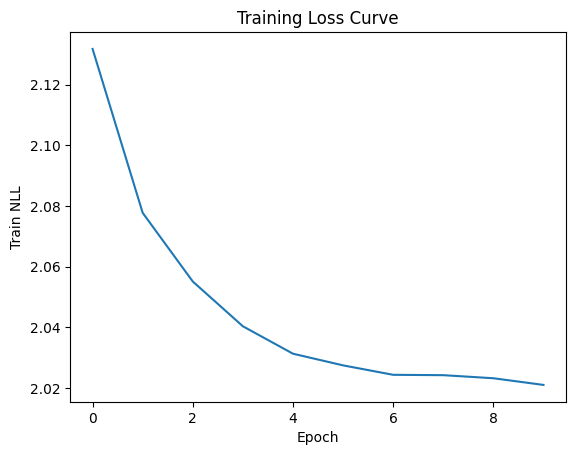

TEST Acc: 1.0

TEST metrics: {'MSE': 4.888051986694336, 'RMSE': 2.2108938694000244, 'MAE': 1.7129168510437012, 'Cov@1σ': 0.6460176706314087, 'NLL': 1.948844313621521, 'Acc': 1.0}
Final test metrics: {'MSE': 4.888051986694336, 'RMSE': 2.2108938694000244, 'MAE': 1.7129168510437012, 'Cov@1σ': 0.6460176706314087, 'NLL': 1.948844313621521, 'Acc': 1.0}


In [5]:
from torch.utils.data import TensorDataset, DataLoader

# Example: y = x0 - 2*x1 + 0.5*x2
B = 512
d_in = 3
X = torch.randn(B, d_in)
y = (X[:, 0] - 2.0 * X[:, 1] + 0.5 * X[:, 2]).unsqueeze(1)  # (B,1)

device = "cuda" if torch.cuda.is_available() else "cpu"
bnn = BNN_GMM(layer_sizes=[3, 4, 1], K=1, bias=True).to(device)
bnn.reset_parameters_normal01_all_layers()

#train_test_split_train_and_eval(bnn, X, y, loss_function=gmm_nll, epochs=20, lr=1e-2, device=device)

dl_train, dl_test = split_dataset(
    X,
    y,
    test_ratio=0.22,
    batch_size=16,
)

losses = train_bnn(
    bnn,
    dl_train,
    gmm_nll,
    epochs=10,
    lr=1e-2,
    input_sigma=1e-2,
    eps=1e-12,
    last_relu=False,
    device=device,
    max_components=50,
)

# plot the loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train NLL")
plt.title("Training Loss Curve")
plt.show()

test_metrics = evaluate_bnn(
    bnn,
    dl_test,
    gmm_nll,
    input_sigma=1e-2,
    eps=1e-12,
    last_relu=False,
    device=device,
    max_components=50,
    )

print("Final test metrics:", test_metrics)


In [6]:
# Load MNIST train split (we'll do train/test split inside your function)
X, y = load_mnist_onehot_tensors(
    root="./data",
    train=True,
    n_max=5000,
    normalize=True,
    device=device,
    dtype=torch.float32,
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 461kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.48MB/s]


In [7]:
device

'cuda'

In [8]:
test_metrics = evaluate_bnn(
    bnn,
    dl_test,
    classification_nll_var_approx,
    input_sigma=1e-2,
    eps=1e-12,
    last_relu=False,
    device=device,
    max_components=10,
    )

print("Final test metrics:", test_metrics)

TEST Acc: 1.0

TEST metrics: {'MSE': 4.8621954917907715, 'RMSE': 2.205038547515869, 'MAE': 1.708877444267273, 'Cov@1σ': 0.6283186078071594, 'NLL': 0.0, 'Acc': 1.0}
Final test metrics: {'MSE': 4.8621954917907715, 'RMSE': 2.205038547515869, 'MAE': 1.708877444267273, 'Cov@1σ': 0.6283186078071594, 'NLL': 0.0, 'Acc': 1.0}


epoch 1/5 | train NLL 2.231074
epoch 2/5 | train NLL 2.065928
epoch 3/5 | train NLL 1.913273
epoch 4/5 | train NLL 1.741819
epoch 5/5 | train NLL 1.559682
Training time: 643.4456763267517


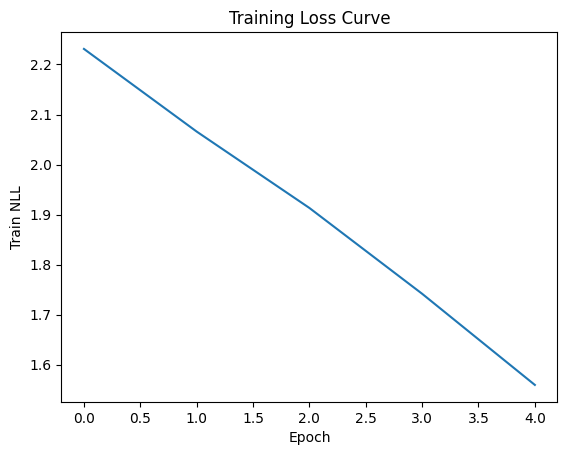

In [9]:
# Example architecture
# NOTE: pick sizes you like; this is a reasonable start.
layer_sizes = [784, 100, 10]
K = 1

bnn = BNN_GMM(layer_sizes=layer_sizes, K=K, bias=True)
bnn.reset_parameters_normal01_all_layers()

#device = "cuda" if torch.cuda.is_available() else "cpu"
bnn.to(device)


dl_train, dl_test = split_dataset(
    X,
    y,
    test_ratio=0.22,
    batch_size=64,
)

time_start = time.time()
losses = train_bnn(
    bnn,
    dl_train,
    classification_nll_var_approx,
    epochs=5,
    lr=1e-3,
    input_sigma=1e-2,
    eps=1e-12,
    last_relu=False,
    device=device,
    max_components=50,
)
time_end = time.time()
print("Training time:", time_end - time_start)

# plot the loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train NLL")
plt.title("Training Loss Curve")
plt.show()



In [10]:
test_metrics = evaluate_bnn(
    bnn,
    dl_test,
    classification_nll_var_approx,
    input_sigma=1e-2,
    eps=1e-12,
    last_relu=False,
    device=device,
    max_components=50,
    )

print("Final test metrics:", test_metrics)

TEST Acc: 0.5454545617103577

TEST metrics: {'MSE': 44676.08203125, 'RMSE': 211.36717224121094, 'MAE': 172.76231384277344, 'Cov@1σ': 0.7244545221328735, 'NLL': 1.4560317993164062, 'Acc': 0.5454545617103577}
Final test metrics: {'MSE': 44676.08203125, 'RMSE': 211.36717224121094, 'MAE': 172.76231384277344, 'Cov@1σ': 0.7244545221328735, 'NLL': 1.4560317993164062, 'Acc': 0.5454545617103577}


In [11]:
bnn.layers[0].mu_w.squeeze(2).T.shape

torch.Size([784, 100])

Evaluate the same model (some weights and bias) with PYRO

In [12]:
import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as dist

@torch.no_grad()
def bnn_forward_fixed_loc_scale(
    x,
    y=None,
    layer_sizes=(784, 100, 10),
    learned_params=None,
    num_samples=1,
    device=None,
    eps=1e-8,
):
    assert learned_params is not None, "Pass learned_params dict with mu/sigma tensors."

    if x.dim() == 4:
        x = x.view(x.size(0), -1)

    if device is None:
        device = x.device
    x = x.to(device)

    if y is not None:
        y = y.to(device)
        if y.dim() == 2 and y.size(-1) == layer_sizes[-1]:
            y = y.argmax(dim=-1)
        y = y.long()

    in_dim, hid_dim, out_dim = layer_sizes
    B = x.size(0)
    S = num_samples

    # Fetch fixed loc/scale
    w1_mu = learned_params["w1_mu"].to(device)
    w1_sg = learned_params["w1_sigma"].to(device).clamp_min(eps)
    b1_mu = learned_params["b1_mu"].to(device)
    b1_sg = learned_params["b1_sigma"].to(device).clamp_min(eps)

    w2_mu = learned_params["w2_mu"].to(device)
    w2_sg = learned_params["w2_sigma"].to(device).clamp_min(eps)
    b2_mu = learned_params["b2_mu"].to(device)
    b2_sg = learned_params["b2_sigma"].to(device).clamp_min(eps)

    def model(x, y=None):
        if S > 1:
            # Explicit dims:
            # - particles at dim=-2
            # - data at dim=-1
            with pyro.plate("particles", S, dim=-2):
                # weights/biases vary by particle, NOT by datapoint
                w1 = pyro.sample("w1", dist.Normal(w1_mu, w1_sg).to_event(2))
                b1 = pyro.sample("b1", dist.Normal(b1_mu, b1_sg).to_event(1))
                w2 = pyro.sample("w2", dist.Normal(w2_mu, w2_sg).to_event(2))
                b2 = pyro.sample("b2", dist.Normal(b2_mu, b2_sg).to_event(1))

                # x: (B,in) -> (S,B,in) via broadcasting
                xS = x.unsqueeze(0).expand(S, B, in_dim)

                # w1: (in,hid) ; b1: (hid,)
                h = F.relu(torch.matmul(xS, w1) + b1.unsqueeze(-2))   # (S,B,hid)
                logits = torch.matmul(h, w2) + b2.unsqueeze(-2)       # (S,B,out)

                with pyro.plate("data", B, dim=-1):
                    if y is None:
                        pyro.sample("obs", dist.Categorical(logits=logits))
                    else:
                        yS = y.unsqueeze(0).expand(S, B)              # (S,B)
                        pyro.sample("obs", dist.Categorical(logits=logits), obs=yS)

                return logits

        else:
            w1 = pyro.sample("w1", dist.Normal(w1_mu, w1_sg).to_event(2))
            b1 = pyro.sample("b1", dist.Normal(b1_mu, b1_sg).to_event(1))
            w2 = pyro.sample("w2", dist.Normal(w2_mu, w2_sg).to_event(2))
            b2 = pyro.sample("b2", dist.Normal(b2_mu, b2_sg).to_event(1))

            h = F.relu(x @ w1 + b1)
            logits = h @ w2 + b2

            with pyro.plate("data", B):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
            return logits

    pyro.clear_param_store()
    tr = pyro.poutine.trace(model).get_trace(x, y)
    return tr.nodes["_RETURN"]["value"]

In [13]:
learned_params = {
    "w1_mu": bnn.layers[0].mu_w.squeeze(2).T, "w1_sigma": bnn.layers[0].sigma_w.squeeze(2).T,
    "b1_mu": bnn.layers[0].mu_b.squeeze(1), "b1_sigma": bnn.layers[0].sigma_b.squeeze(1),
    "w2_mu": bnn.layers[1].mu_w.squeeze(2).T, "w2_sigma": bnn.layers[1].sigma_w.squeeze(2).T,
    "b2_mu": bnn.layers[1].mu_b.squeeze(1), "b2_sigma": bnn.layers[1].sigma_b.squeeze(1),
}
x = X[0]
xb = x.unsqueeze(0)
yb = y[0].unsqueeze(0)
logits_1 = bnn_forward_fixed_loc_scale(xb, yb, learned_params=learned_params, num_samples=1, device=device)
logits_S = bnn_forward_fixed_loc_scale(xb, yb, learned_params=learned_params, num_samples=50, device=device)
probs = logits_S.softmax(-1).mean(0)

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def predictive_stats_anyshape(logits):
    """
    logits: tensor with last dimension = C (classes).
            Can be (S,B,C), (S,S,B,C), (50,50,1,10), etc.

    Returns:
      mean_c: (C,)
      var_c:  (C,)   variance of p(y=c|x) over all non-class dims
    """
    probs = logits#.softmax(dim=-1)  # (..., C)

    reduce_dims = tuple(range(probs.dim() - 1))  # all dims except class dim
    mean_c = probs.mean(dim=reduce_dims)         # (C,)
    var_c  = probs.var(dim=reduce_dims, unbiased=False)  # (C,)
    return mean_c, var_c


def plot_mean_and_variance(mean_c, var_c, title="Posterior Predictive Mean ± Std per Class"):
    mean_np = mean_c.detach().cpu().numpy()
    std_np  = torch.sqrt(var_c.clamp_min(0)).detach().cpu().numpy()

    C = mean_np.shape[0]
    x = np.arange(C)

    plt.figure()
    plt.bar(x, mean_np, yerr=std_np, capsize=4)
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.title(title)
    plt.xticks(x)
    plt.show()

def predictive_stats_from_gmm(pi_out, mu_out, sg_out):
    """
    pi_out : (..., C, K)
    mu_out : (..., C, K)
    sg_out : (..., C, K)

    Returns:
        mean_c: (C,)
        var_c : (C,)
    """

    # Remove batch dims if B=1
    pi = pi_out.squeeze()
    mu = mu_out.squeeze()
    sg = sg_out.squeeze()

    # Now shapes should be (C,K)
    assert pi.dim() == 2, f"Expected (C,K), got {pi.shape}"

    # Mean: E[p]
    mean_c = (pi * mu).sum(dim=-1)

    # Second moment: E[p^2]
    second_moment = (pi * (sg**2 + mu**2)).sum(dim=-1)

    # Variance
    var_c = second_moment - mean_c**2

    return mean_c, var_c

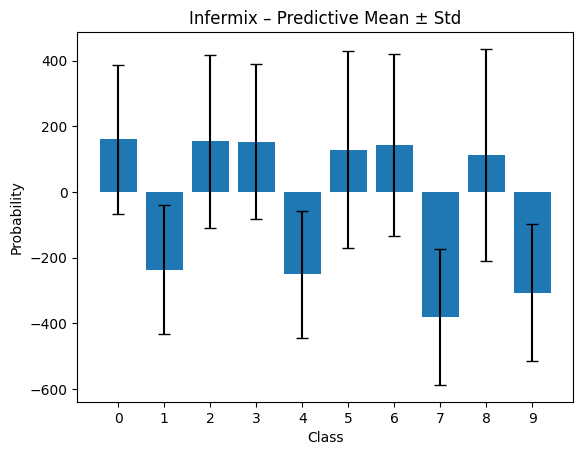

In [21]:
bnn.eval()

with torch.no_grad():

    # Deterministic input → GMM input (1, D, 1)
    pi_x = torch.ones(1, xb.shape[1], 1, device=device, dtype=xb.dtype)
    mu_x = xb.unsqueeze(-1)
    sg_x = 0.01 * torch.ones_like(mu_x)

    pi_out, mu_out, sg_out = bnn(
        pi_x, mu_x, sg_x,
        last_relu=False,
        max_components=50,
    )
pi_out.shape
mu_out

logits = (pi_out * mu_out).sum(dim=-1)

mean_c, var_c = predictive_stats_from_gmm(pi_out, mu_out, sg_out)

plot_mean_and_variance(mean_c, var_c,
                       title="Infermix – Predictive Mean ± Std")

Predictive mean per class:
 tensor([ 119.3772, -166.4007,  124.7888,  158.1444, -136.6904,   97.1220,
          16.0679, -336.8214,  130.0333, -293.9181], device='cuda:0')
Predictive variance per class:
 tensor([ 40793.4258,  33807.2305,  62411.1055,  42541.3359,  33547.6016,
         95803.1250,  53720.8008,  53442.4961, 103185.9609,  43954.5078],
       device='cuda:0')


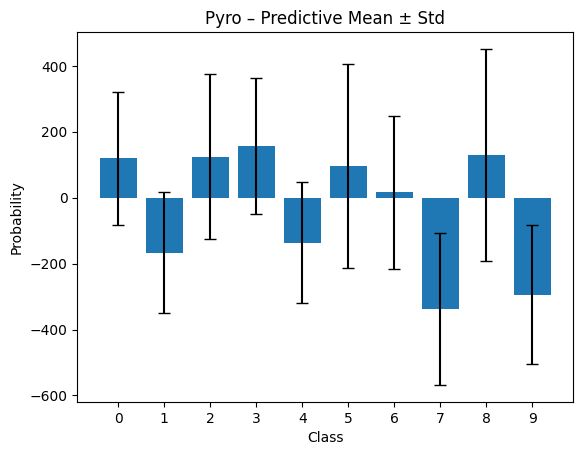

In [22]:
mean_pyro, var_pyro = predictive_stats_anyshape(logits_S)

#print("logits_S shape:", logits_S.shape)
#print("mean_c shape:", mean_c.shape, "var_c shape:", var_c.shape)
print("Predictive mean per class:\n", mean_pyro)
print("Predictive variance per class:\n", var_pyro)

plot_mean_and_variance(mean_pyro, var_pyro, title="Pyro – Predictive Mean ± Std")

In [23]:
def rmse(a,b): return torch.sqrt(((a-b)**2).mean())
print("RMSE mean logits:", rmse(mean_c, mean_pyro).item())

RMSE mean logits: 63.014404296875


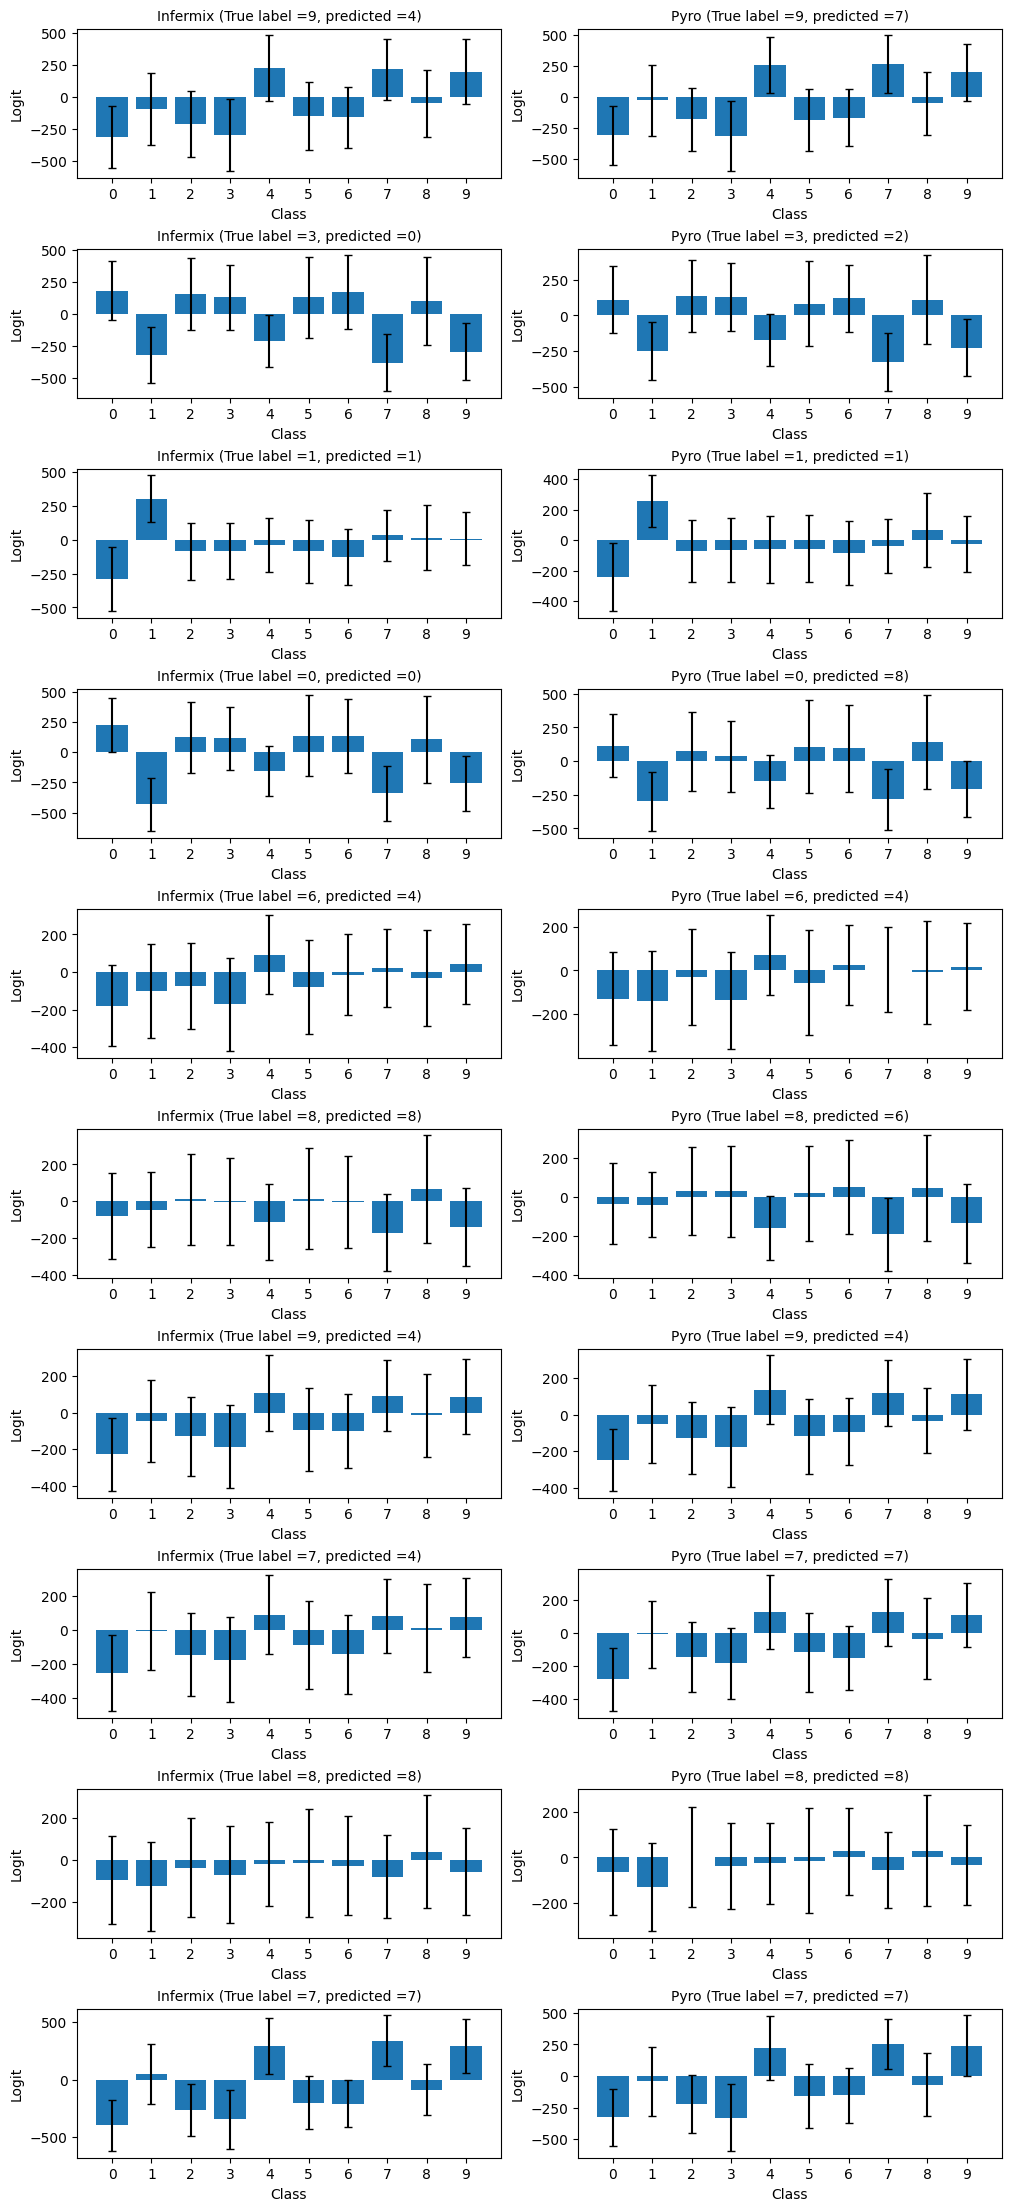

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def predictive_stats_anyshape_logits(logits):
    """
    logits: tensor with last dim = C
    Returns mean_c, var_c over all dims except last.
    """
    rd = tuple(range(logits.dim() - 1))
    mean_c = logits.mean(dim=rd)
    var_c = logits.var(dim=rd, unbiased=False)
    return mean_c, var_c

@torch.no_grad()
def predictive_stats_from_gmm_logits(pi_out, mu_out, sg_out, eps=1e-12):
    """
    Analytic mean/var of a class-wise GMM in logit space.
    Accepts shapes (..., C, K) with any leading dims (often batch=1).
    Returns (C,), (C,) by reducing leading dims (keeping classes).
    """
    pi = pi_out.clamp_min(0)
    pi = pi / (pi.sum(dim=-1, keepdim=True) + eps)
    mu = mu_out
    sg = sg_out.clamp_min(0)

    mean = (pi * mu).sum(dim=-1)                    # (..., C)
    second = (pi * (sg**2 + mu**2)).sum(dim=-1)     # (..., C)
    var = second - mean**2                          # (..., C)

    rd = tuple(range(mean.dim() - 1))               # reduce leading dims -> (C,)
    if len(rd) > 0:
        mean = mean.mean(dim=rd)
        var = var.mean(dim=rd)
    return mean, var

def plot_compare_grid_10x2(
    X, y,
    bnn, learned_params,
    device,
    bnn_forward_fixed_loc_scale_fn,
    n_points=10,
    num_samples_pyro=50,
    input_sigma=0.01,
    max_components=50,
    layer_sizes=(784, 100, 10),
    last_relu=False,
):
    """
    Creates a n_points x 2 grid:
      row i: left = Infermix mean±std over classes (logit space)
             right = Pyro mean±std over classes (logit space)

    Assumes:
      - X is tensor (N, ...) and y is (N,)
      - bnn returns (pi_out, mu_out, sg_out)
      - bnn_forward_fixed_loc_scale_fn returns logits samples with last dim=C
    """
    bnn.eval()
    n_points = min(n_points, X.shape[0])

    fig, axes = plt.subplots(n_points, 2, figsize=(10, 2.2 * n_points), constrained_layout=True)
    if n_points == 1:
        axes = np.array([axes])  # normalize shape

    def _plot_bar(ax, mean_c, var_c, title):
        mean_np = mean_c.detach().cpu().numpy()
        std_np = torch.sqrt(var_c.clamp_min(0)).detach().cpu().numpy()
        C = mean_np.shape[0]
        xs = np.arange(C)

        ax.bar(xs, mean_np, yerr=std_np, capsize=3)
        ax.set_xticks(xs)
        ax.set_xlabel("Class")
        ax.set_ylabel("Logit")
        ax.set_title(title, fontsize=10)

    for i in range(n_points):
        xb = X[i].unsqueeze(0).to(device)
        yb = y[i].unsqueeze(0).to(device)
        true_lbl = int(y[i].item()) if hasattr(y[i], "item") else int(y[i])

        # ---- Pyro: sample logits ----
        logits_S = bnn_forward_fixed_loc_scale_fn(
            xb, yb,
            layer_sizes=layer_sizes,
            learned_params=learned_params,
            num_samples=num_samples_pyro,
            device=device
        )
        mean_pyro, var_pyro = predictive_stats_anyshape_logits(logits_S)
        predicted_class_pyro = torch.argmax(mean_pyro).item()

        # ---- Infermix: analytic logits moments ----
        xb_flat = xb.view(1, -1) if xb.dim() == 4 else xb
        pi_x = torch.ones(1, xb_flat.shape[1], 1, device=device, dtype=xb_flat.dtype)
        mu_x = xb_flat.unsqueeze(-1)
        sg_x = input_sigma * torch.ones_like(mu_x)

        with torch.no_grad():
            pi_out, mu_out, sg_out = bnn(pi_x, mu_x, sg_x, last_relu=last_relu, max_components=max_components)

        mean_inf, var_inf = predictive_stats_from_gmm_logits(pi_out, mu_out, sg_out)
        predicted_class_inf = torch.argmax(mean_inf).item()

        _plot_bar(axes[i, 0], mean_inf, var_inf, f"Infermix (True label ={true_lbl}, predicted ={predicted_class_inf})")
        _plot_bar(axes[i, 1], mean_pyro, var_pyro, f"Pyro (True label ={true_lbl}, predicted ={predicted_class_pyro})")

    plt.show()


def extract_from_dataloader(dl):
    xs = []
    ys = []
    for xb, yb in dl:
        xs.append(xb)
        ys.append(yb)
    return torch.cat(xs, dim=0), torch.cat(ys, dim=0)

X_test, y_test = extract_from_dataloader(dl_test)

if y_test.dim() == 2 and y_test.size(-1) == 10:
    y_test_idx = y_test.argmax(dim=-1)
else:
    y_test_idx = y_test

plot_compare_grid_10x2(
    X=X_test, y=y_test_idx,                 # or X, y
    bnn=bnn,
    learned_params=learned_params,
    device=device,
    bnn_forward_fixed_loc_scale_fn=bnn_forward_fixed_loc_scale,
    n_points=10,
    num_samples_pyro=200,
    input_sigma=0.01,
    max_components=50,
    layer_sizes=(784, 100, 10),
    last_relu=False,
)

In [39]:
import torch

@torch.no_grad()
def pyro_fixed_params_accuracy(
    dl_test,
    bnn_forward_fixed_loc_scale_fn,
    learned_params,
    device,
    layer_sizes=(784, 100, 10),
    num_samples=50,
):
    """
    Estimate classification accuracy of the Pyro model with FIXED (mu,sigma) parameters.

    For each batch:
      - draw S samples of weights
      - compute logits for each sample
      - average softmax probs over samples
      - predict argmax class
      - compute accuracy vs labels

    Works whether y is class indices (B,) or one-hot (B,C).
    """
    correct = 0
    total = 0

    for xb, yb in dl_test:
        xb = xb.to(device)
        yb = yb.to(device)

        # If labels are one-hot/probabilities, convert to indices
        if yb.dim() == 2 and yb.size(-1) == layer_sizes[-1]:
            y_idx = yb.argmax(dim=-1)
        else:
            y_idx = yb.long()

        # IMPORTANT: don't pass y to the model for prediction;
        # we just want forward samples -> predictive distribution.
        logits_S = bnn_forward_fixed_loc_scale_fn(
            xb,
            y=None,
            layer_sizes=layer_sizes,
            learned_params=learned_params,
            num_samples=num_samples,
            device=device,
        )

        # logits_S may have extra sample dims (as you saw before),
        # so compute probs and average over ALL dims except (B,C) / class dim.
        probs = logits_S.softmax(dim=-1)

        # Reduce all dims except the last (class) and the batch dim.
        # We want final shape (B,C).
        # Strategy: reshape everything to (-1, B, C) then mean over first dim.
        B = xb.size(0)
        C = probs.size(-1)
        probs = probs.reshape(-1, B, C).mean(dim=0)   # (B,C)

        pred = probs.argmax(dim=-1)                   # (B,)
        correct += (pred == y_idx).sum().item()
        total += B

    return correct / total


acc = pyro_fixed_params_accuracy(
    dl_test=dl_test,
    bnn_forward_fixed_loc_scale_fn=bnn_forward_fixed_loc_scale,
    learned_params=learned_params,
    device=device,
    layer_sizes=(784, 100, 10),
    num_samples=200,
)
print(f"Pyro (fixed params) test accuracy: {acc*100:.2f}%")

Pyro (fixed params) test accuracy: 43.55%


In [ ]:
import math
import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as dist

def bnn_model_xavier_like(x, y=None, layer_sizes=(784, 100, 10), prior_scale = None):
    if x.dim() == 4:
        x = x.view(x.size(0), -1)

    # ensure labels are class indices
    if y is not None and y.dim() == 2:
        y = y.argmax(dim=-1)
    if y is not None:
        y = y.long()

    in_dim, hid_dim, out_dim = layer_sizes

    # Match Var(U(-bound,bound)) where bound=1/sqrt(fan_in): std = bound/sqrt(3)
    std1 = (1.0 / math.sqrt(in_dim)) / math.sqrt(3.0)
    std2 = (1.0 / math.sqrt(hid_dim)) / math.sqrt(3.0)

    # Put priors on the same device/dtype as x
    loc = x.new_tensor(0.0)

    w1 = pyro.sample("w1",
        dist.Normal(loc, x.new_tensor(std1)).expand([in_dim, hid_dim]).to_event(2)
    )
    b1 = pyro.sample("b1",
        dist.Normal(loc, x.new_tensor(std1)).expand([hid_dim]).to_event(1)
    )
    w2 = pyro.sample("w2",
        dist.Normal(loc, x.new_tensor(std2)).expand([hid_dim, out_dim]).to_event(2)
    )
    b2 = pyro.sample("b2",
        dist.Normal(loc, x.new_tensor(std2)).expand([out_dim]).to_event(1)
    )

    h = F.relu(x @ w1 + b1)
    logits = h @ w2 + b2

    with pyro.plate("data", x.size(0)):
        pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

    return logits

In [ ]:
bnn.eval()

for i in range(5):
    with torch.no_grad():
        x = X[i]  # (D,)
        x = x.to(device)

        # (1, D)
        x = x.unsqueeze(0)

        # Deterministic input → GMM input (1, D, 1)
        pi_x = torch.ones(1, x.shape[1], 1, device=device, dtype=x.dtype)
        mu_x = x.unsqueeze(-1)
        sg_x = 0.01 * torch.ones_like(mu_x)

        pi_out, mu_out, sg_out = bnn(
            pi_x, mu_x, sg_x,
            last_relu=False,
            max_components=50,
        )
    pi_out.shape
    mu_out

    logits = (pi_out * mu_out).sum(dim=-1)

    # convert one-hot to class indices
    y_idx = torch.argmax(y[i], dim=0)

    print("Predicted class:", torch.argmax(logits, dim=1).item())
    print("True class:", y_idx.item())

Predicted class: 3
True class: 5
Predicted class: 0
True class: 0
Predicted class: 4
True class: 4
Predicted class: 1
True class: 1
Predicted class: 9
True class: 9


In [ ]:
# Pyro BNN for MNIST (1 hidden layer): layer_sizes = [784, 100, 10]
# Supports BOTH:
#  (A) Variational Inference (SVI) via AutoDiagonalNormal
#  (B) MCMC via NUTS
#
# Notes:
# - MCMC over ~ (784*100 + 100 + 100*10 + 10) = 79,510 parameters is HEAVY.
#   In practice, run NUTS on a SMALL subset (e.g., 256–2,000 points) or reduce hidden size.
# - VI (SVI) works fine with minibatches; NUTS typically needs full-batch likelihood.

import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

#pyro.set_rng_seed(0)
pyro.clear_param_store()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


def bnn_model(x, y=None, layer_sizes=(784, 100, 10), prior_scale=1.0):
    if x.dim() == 4:
        x = x.view(x.size(0), -1)

    x = x.to(device)
    if y is not None:
        y = y.to(device)
        if y.dim() == 2 and y.size(-1) == layer_sizes[-1]:
            y = y.argmax(dim=-1)
        y = y.long()

    in_dim, hid_dim, out_dim = layer_sizes

    loc = x.new_tensor(0.0)
    scale = x.new_tensor(prior_scale)

    w1 = pyro.sample("w1", dist.Normal(loc, scale).expand([in_dim, hid_dim]).to_event(2))
    b1 = pyro.sample("b1", dist.Normal(loc, scale).expand([hid_dim]).to_event(1))
    w2 = pyro.sample("w2", dist.Normal(loc, scale).expand([hid_dim, out_dim]).to_event(2))
    b2 = pyro.sample("b2", dist.Normal(loc, scale).expand([out_dim]).to_event(1))

    h = F.relu(x @ w1 + b1)
    logits = h @ w2 + b2

    with pyro.plate("data", x.size(0)):
        pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

    return logits


# ----------------------------
# VI training (SVI)
# ----------------------------
def train_vi(
    train_dl,
    test_dl,
    layer_sizes=(784, 100, 10),
    prior_scale=1.0,
    lr=1e-3,
    num_epochs=5,
    num_particles=1,  # increase for lower-variance gradients (slower)
    bnn_model = bnn_model
):
    pyro.clear_param_store()

    # Auto guide (mean-field diagonal Gaussian over all latent params)
    guide = AutoDiagonalNormal(lambda x, y=None: bnn_model(x, y, layer_sizes, prior_scale))

    optim = Adam({"lr": lr})
    elbo = Trace_ELBO(num_particles=num_particles)
    svi = SVI(lambda x, y=None: bnn_model(x, y, layer_sizes, prior_scale), guide, optim, elbo)

    def eval_accuracy_mc(num_samples=50):
        """
        MC estimate of predictive accuracy by sampling weights from guide.
        """
        predictive = Predictive(
            lambda x, y=None: bnn_model(x, y, layer_sizes, prior_scale),
            guide=guide,
            num_samples=num_samples,
            return_sites=("obs",)
        )

        correct, total = 0, 0
        for xb, yb in test_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            # one-hot (N,10) -> indices (N,)
            if yb.dim() == 2 and yb.size(-1) == 10:
                yb = yb.argmax(dim=-1)
            yb = yb.long()
            # predictive returns sampled 'obs' (labels) or you can return logits explicitly
            samples = predictive(xb, None)
            # samples["obs"]: (S, N) sampled labels; do majority vote
            preds = samples["obs"].mode(dim=0).values
            correct += (preds == yb).sum().item()
            total += yb.numel()
        return correct / max(total, 1)

    for epoch in range(1, num_epochs + 1):
        total_loss = 0.0
        total_n = 0

        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            # one-hot (N,10) -> indices (N,)
            if yb.dim() == 2 and yb.size(-1) == 10:
                yb = yb.argmax(dim=-1)
            yb = yb.long()
            loss = svi.step(xb, yb)  # negative ELBO (sum over batch)
            total_loss += loss
            total_n += xb.size(0)

        avg_nll = total_loss / max(total_n, 1)
        acc = eval_accuracy_mc(num_samples=30)
        print(f"[VI] epoch {epoch:02d} | negELBO/pt ~ {avg_nll:.4f} | test acc (MC) ~ {acc:.4f}")

    return guide


# ----------------------------
# MCMC training (NUTS)
# ----------------------------
def run_mcmc(
    train_dl_fullbatch,  # IMPORTANT: for NUTS, typically do full-batch likelihood
    layer_sizes=(784, 100, 10),
    prior_scale=1.0,
    num_warmup=200,
    num_samples=200,
    max_tree_depth=5,
):
    pyro.clear_param_store()

    # Build a single full batch tensor (recommended for MCMC)
    xs, ys = [], []
    for xb, yb in train_dl_fullbatch:
        xs.append(xb)
        ys.append(yb)
    x_train = torch.cat(xs, dim=0).to(device)
    y_train = torch.cat(ys, dim=0).to(device)

    def model_for_mcmc():
        bnn_model(x_train, y_train, layer_sizes=layer_sizes, prior_scale=prior_scale)

    nuts_kernel = NUTS(model_for_mcmc, max_tree_depth=max_tree_depth)
    mcmc = MCMC(nuts_kernel, warmup_steps=num_warmup, num_samples=num_samples)
    mcmc.run()
    posterior_samples = mcmc.get_samples()
    return mcmc, posterior_samples


def mcmc_predict_accuracy(posterior_samples, test_dl, layer_sizes=(784, 100, 10), prior_scale=1.0, num_samples=None):
    """
    Predictive accuracy using posterior samples from MCMC.
    If num_samples is not None, uses only that many samples from the posterior.
    """
    # Optionally subsample posterior draws
    if num_samples is not None:
        idx = torch.randperm(next(iter(posterior_samples.values())).size(0))[:num_samples]
        posterior_samples = {k: v[idx] for k, v in posterior_samples.items()}

    predictive = Predictive(
        lambda x, y=None: bnn_model(x, y, layer_sizes, prior_scale),
        posterior_samples=posterior_samples,
        return_sites=("obs",)
    )

    correct, total = 0, 0
    for xb, yb in test_dl:
      xb = xb.to(device)
      yb = yb.to(device)

      # one-hot (N,10) -> indices (N,)
      if yb.dim() == 2 and yb.size(-1) == layer_sizes[-1]:
          yb = yb.argmax(dim=-1)
      yb = yb.long()

      samples = predictive(xb, None)
      preds = samples["obs"].mode(dim=0).values  # (N,)

      correct += (preds == yb).sum().item()
      total += yb.numel()

    return correct / max(total, 1)

device: cuda


In [ ]:
# ----------------------------
# Example usage
# ----------------------------
# 1) VI (fast, minibatch-friendly)

time_start = time.time()
guide = train_vi(
    train_dl=dl_train,
    test_dl=dl_test,
    layer_sizes=(784, 100, 10),
    prior_scale=1.0,
    lr=1e-4,
    num_epochs=100,
    num_particles=1,
    bnn_model = bnn_model_xavier_like
)
time_end = time.time()
print("Training time:", time_end - time_start)

[VI] epoch 01 | negELBO/pt ~ 11906.2861 | test acc (MC) ~ 0.0800
[VI] epoch 02 | negELBO/pt ~ 11799.0645 | test acc (MC) ~ 0.1136
[VI] epoch 03 | negELBO/pt ~ 11716.3410 | test acc (MC) ~ 0.1027
[VI] epoch 04 | negELBO/pt ~ 11629.5207 | test acc (MC) ~ 0.1145
[VI] epoch 05 | negELBO/pt ~ 11529.6461 | test acc (MC) ~ 0.1073
[VI] epoch 06 | negELBO/pt ~ 11434.7821 | test acc (MC) ~ 0.1000
[VI] epoch 07 | negELBO/pt ~ 11357.2122 | test acc (MC) ~ 0.1018
[VI] epoch 08 | negELBO/pt ~ 11266.0145 | test acc (MC) ~ 0.0827
[VI] epoch 09 | negELBO/pt ~ 11171.1441 | test acc (MC) ~ 0.1245
[VI] epoch 10 | negELBO/pt ~ 11082.2494 | test acc (MC) ~ 0.1018
[VI] epoch 11 | negELBO/pt ~ 10996.2239 | test acc (MC) ~ 0.1155
[VI] epoch 12 | negELBO/pt ~ 10921.4975 | test acc (MC) ~ 0.1209
[VI] epoch 13 | negELBO/pt ~ 10843.9744 | test acc (MC) ~ 0.0900
[VI] epoch 14 | negELBO/pt ~ 10757.2751 | test acc (MC) ~ 0.0955
[VI] epoch 15 | negELBO/pt ~ 10679.3903 | test acc (MC) ~ 0.1200
[VI] epoch 16 | negELBO/p

In [ ]:
# 2) MCMC (NUTS)

mcmc, posterior = run_mcmc(
    train_dl_fullbatch=dl_train,
    layer_sizes=(784, 100, 10),
    prior_scale=1.0,
    num_warmup=200,
    num_samples=2000,
    max_tree_depth=5,
)

In [ ]:
acc_mcmc = mcmc_predict_accuracy(
    posterior_samples=posterior,
    test_dl=dl_test,
    layer_sizes=(784, 100, 10),
    prior_scale=1.0,
    num_samples=100
)

print(f"[MCMC] test acc (posterior vote) ~ {acc_mcmc:.4f}")